### Quickstart Tutorial

#### 1.1 Fast Light Curves

As a simple first example, we will use $\texttt{eleanor}$ to create a target pixel file (TPF) and light curve for a given TIC target.

In [1]:
from IPython.display import Image

In [2]:
import eleanor
import numpy as np
import matplotlib.pyplot as plt

First, we will load the data for TIC 38846515 (WASP-100), a relatively bright star observed in Sector 1. $\texttt{eleanor}$ is able to extract a light curve easily and automatically for this unblended object. Calling source will assign a $\textit{Gaia}$ ID, TESS magnitude, sector, camera, ccd, and associated postcard.

In [3]:
star = eleanor.Source(tic=38846515, sector=1)


Now that we have our Source information, we simply called the TargetData() function, which will extract a target pixel file, perform aperture photometry with an automatically optimized aperture choice, and complete some simple systematics corrections.

In [4]:
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True)


/Users/ozymandias1/anaconda2/envs/python3/lib/python3.5/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)
/Users/ozymandias1/anaconda2/envs/python3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
100%|██████████| 1282/1282 [00:13<00:00, 92.35it/s]


$\texttt{eleanor}$ may download a file here. Don't be afraid of this download. We have created an intermediate step between FFIs and TPFs called $\textbf{postcards}$. In order to create a TPF, $\texttt{eleanor}$ downloads the postcard your source falls on. We'll talk through the flags you can set, but let's look at a light curve first.

Text(0.5,0,'Time')

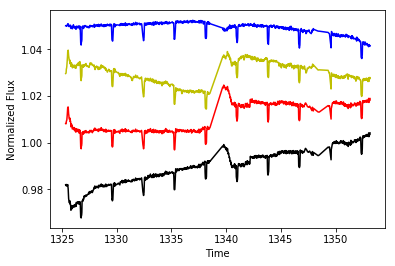

In [5]:
q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.median(data.raw_flux[q])-0.01, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.median(data.corr_flux[q]) + 0.01, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.median(data.pca_flux[q]) + 0.03, 'y')
plt.plot(data.time[q], data.psf_flux[q]/np.median(data.psf_flux[q]) + 0.05, 'b')

plt.ylabel('Normalized Flux')
plt.xlabel('Time')

There's a planet there! What does our aperture look like?

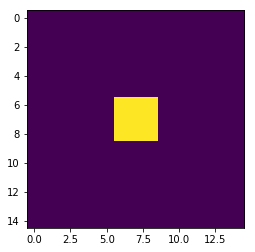

In [6]:
plt.imshow(data.aperture)

Let's save these data to a FITS file so we have them later. By default, this will be saved to a `~/.eleanor` directory, but that can be changed by setting a `directory`.

In [7]:
data.save()

#### 1.2 Custom Apertures

That was easy! But what if you're not satisfied with $\texttt{eleanor}$'s default choice of aperture? Well, we provide you with two ways to create your own aperture.

(1) $\texttt{eleanor}$ can help you create your own mask. By calling custom_aperture, you can choose from a circular or rectangular aperture. You can also choose the size (radius or length x width) and the pixel the aperture is centered on. The aperture will only be created on pixels within the TPF (it won't spill over to other pixels)

In [8]:
eleanor.TargetData.custom_aperture(data, shape='circle', r=1)
eleanor.TargetData.get_lightcurve(data)

(2) You can pass in your own mask. Create a 2D array of the same shape as your TPF and pass in the aperture using the following command

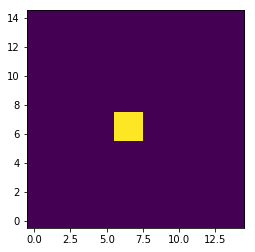

In [9]:
mask = np.zeros(np.shape(data.tpf[0]))
mask[6:8,6:8] = 1
plt.imshow(mask, origin='lower')
data.get_lightcurve(aperture=mask)

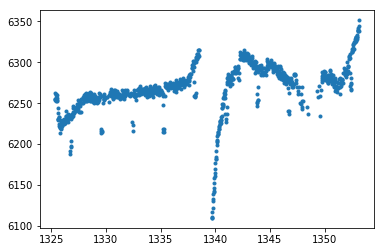

In [10]:
plt.plot(data.time[q], data.raw_flux[q], '.')
plt.show()

##### 1.2.1 Ultra-Custom Apertures: Click the pixels you want!

We have created a user-friendly method to create your own aperture by selecting the pixels you wish to be included in the photometry. Here's how you would go about doing so:

In [11]:
Image(url='customApExample.gif')

Currently, this feature only works when called from the terminal. We are working towards creating an option to embed this feature in a Jupyter Notebook... So stay tuned!

#### 1.3 Systematics Corrections

When we called eleanor.TargetData() in 1.1, some simple systematics corrections were automatically performed on the light curve. Let's apply those explicitly to the newly created raw light curve from the custom aperture.

In [12]:
corr_flux = eleanor.TargetData.jitter_corr(data, flux=data.raw_flux)

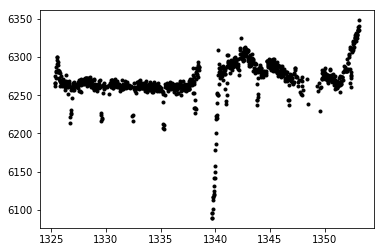

In [13]:
plt.plot(data.time[q], corr_flux[q], 'k.')

We can then run pca with this flux time series to remove any shared systematics with nearby stars.

In [14]:
eleanor.TargetData.pca(data, flux=corr_flux, modes=4)

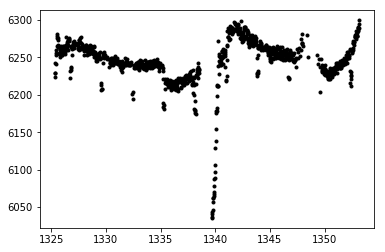

In [15]:
plt.plot(data.time[q], data.pca_flux[q], 'k.')

PSF modeling is always an option too!

100%|██████████| 1282/1282 [00:14<00:00, 85.88it/s]


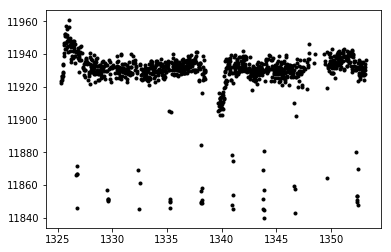

In [16]:
eleanor.TargetData.psf_lightcurve(data, model='gaussian', likelihood='poisson')
plt.plot(data.time[q], data.psf_flux[q], 'k.')

#### 1.4 Good practices

We're still exploring what the best practices are generally. Good practices seem to differ across the detector, but here's what we believe so far. If you discover anything that works well for you, we and other $\texttt{eleanor}$ users would surely love to know them!

Good background subtraction is very important. The size of the region to use for an "ideal" background changes across the detector. Generally, bigger is better, we typically recommend using a region larger than the standard TPF. Currently, the background used must be a rectangle centered on the star, with size `bkg_size`

PSF modeling (`do_psf=True`) seems to work very well for relatively bright, isolated stars. Presently the only PSF model is a Gaussian, but both Gaussian and Poisson likelihood functions are possible. Do note that this requires tensorflow, and there is not presently a tensorflow package for Python 3.7. This will thus only work for python 3.0 - 3.6. Note that PSF modeling is very much in beta and our current implementation has known issues for very faint stars (fainter than I ~ 15, generally).

If you find anything that works well for your science, or uncover any issues, please let us know! Github [issues](https://github.com/afeinstein20/eleanor/issues) or [pull requests](https://github.com/afeinstein20/eleanor/pulls) are welcomed.